In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("dark")

In [2]:
train = pd.read_csv("../data/train_fe.csv")
test = pd.read_csv("../data/test_fe.csv")

In [3]:
train.head()

,area,majoraxislength,minoraxislength,eccentricity,convexarea,extent,perimeter,target
0,0.262568,0.290056,0.254227,0.827058,0.273867,0.646138,0.321550,0.0
1,0.224630,0.140979,0.398693,0.302535,0.229186,0.716253,0.249911,0.0
2,0.287857,0.200529,0.414687,0.495150,0.286038,0.839106,0.274388,0.0
3,0.750744,0.512630,0.676241,0.722318,0.764057,0.775255,0.611673,1.0
4,0.178613,0.253401,0.136156,0.884131,0.179696,0.891770,0.230519,0.0


In [4]:
x_train_use, y_train_use = train.drop("target", axis = 1), train["target"]

In [5]:
#x_train_use = x_train_use.drop_duplicates().reset_index(drop=True)

In [6]:
train.shape

(720, 8)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train_use, y_train_use, train_size=0.8, random_state = 42)

In [8]:
x_train.shape, y_train.shape

((576, 7), (576,))

### Logistic Regression

In [9]:
lr = LogisticRegression()
lr.fit(x_train, np.array(y_train).reshape(-1,1))

LogisticRegression()

In [10]:
y_pred = lr.predict(x_train)

In [11]:
f1_score(y_train, y_pred)

0.8571428571428571

In [12]:
np.linspace(0,1,10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [13]:
lr_pipeline = Pipeline([("lr", LogisticRegression(solver='saga', max_iter=5000))])
param_grid = [{"lr__C":np.linspace(0,1,10), "lr__penalty":["l1","l2", "elasticnet"]}]
grid_search = GridSearchCV(lr_pipeline, param_grid, cv = 5)

In [14]:
grid_search.fit(x_train, np.array(y_train).reshape(-1,1))

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('lr',
                                        LogisticRegression(max_iter=5000,
                                                           solver='saga'))]),
             param_grid=[{'lr__C': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                          'lr__penalty': ['l1', 'l2', 'elasticnet']}])

In [15]:
grid_search.best_params_

{'lr__C': 1.0, 'lr__penalty': 'l2'}

In [16]:
model = grid_search.best_estimator_

In [17]:
model.fit(x_train, y_train)

Pipeline(steps=[('lr', LogisticRegression(max_iter=5000, solver='saga'))])

In [18]:
y_pred = model.predict(x_train)

In [19]:
f1_score(y_train, y_pred)

0.8571428571428571

In [20]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86       288
         1.0       0.88      0.83      0.86       288

    accuracy                           0.86       576
   macro avg       0.86      0.86      0.86       576
weighted avg       0.86      0.86      0.86       576



In [21]:
train["target"].value_counts()

1.0    364
0.0    356
Name: target, dtype: int64

In [22]:
import seaborn as sns; sns.set_style("darkgrid")

In [23]:
def plot_confusion_matrix(title,conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.savefig("../conf/"+title+".png")
    plt.show()

<AxesSubplot:>

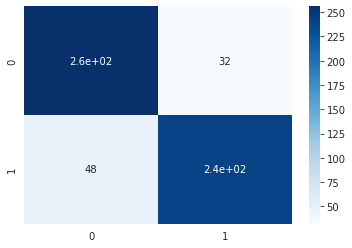

In [24]:
conf = confusion_matrix(y_train, y_pred)
sns.heatmap(conf, annot=True, cmap= "Blues")

In [25]:
y_pred_val = model.predict(x_val)

In [26]:
f1_score(y_val, y_pred_val)

0.8759124087591241

In [27]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

         0.0       0.81      0.99      0.89        68
         1.0       0.98      0.79      0.88        76

    accuracy                           0.88       144
   macro avg       0.90      0.89      0.88       144
weighted avg       0.90      0.88      0.88       144



#### Extracting results

In [28]:
import time
start = time.time()
model.fit(x_train_use, y_train_use)
elapsed = time.time() - start

In [29]:
pred_use = model.predict(x_train_use)

In [30]:
cross_val_score(model, x_train_use, y_train_use, scoring="f1")

array([0.85915493, 0.88275862, 0.86330935, 0.79136691, 0.89855072])

In [31]:
print(classification_report(y_train_use, pred_use))

              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87       356
         1.0       0.89      0.83      0.86       364

    accuracy                           0.86       720
   macro avg       0.87      0.86      0.86       720
weighted avg       0.87      0.86      0.86       720



In [32]:
f1_train = f1_score(y_train_use, pred_use)
prec_train = precision_score(y_train_use, pred_use)
recall_train = recall_score(y_train_use, pred_use)

In [33]:
cols=train.columns
cols

Index(['area', 'majoraxislength', 'minoraxislength', 'eccentricity',
       'convexarea', 'extent', 'perimeter', 'target'],
      dtype='object')

In [34]:
test

,area,majoraxislength,minoraxislength,eccentricity,convexarea,extent,perimeter,target
0,0.333683,0.292740,0.391650,0.709791,0.343346,0.647720,0.367102,0.0
1,0.173967,0.155915,0.263135,0.625985,0.193709,0.707692,0.256525,1.0
2,0.130239,0.075000,0.282310,0.279650,0.134870,0.785545,0.159653,0.0
3,0.416966,0.410640,0.354285,0.850290,0.426486,0.797411,0.445093,1.0
4,0.116832,0.079873,0.225138,0.464827,0.116180,0.848382,0.129657,0.0
...,...,...,...,...,...,...,...,...
175,0.354240,0.267056,0.445044,0.608017,0.376255,0.792897,0.388789,1.0
176,0.494377,0.408450,0.467939,0.773995,0.510237,0.590217,0.484878,1.0
177,0.374549,0.376921,0.333926,0.839922,0.377358,0.683121,0.384308,1.0
178,0.239593,0.184789,0.343547,0.570428,0.241151,0.760365,0.253966,0.0


In [35]:
x_test, y_test = test.drop("target", axis =1), test["target"]

In [36]:
pred_test = model.predict(x_test)

In [37]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86        94
         1.0       0.84      0.86      0.85        86

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180



In [38]:
f1_test = f1_score(y_test, pred_test)
prec_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)

In [39]:
conf = confusion_matrix(y_test, pred_test)

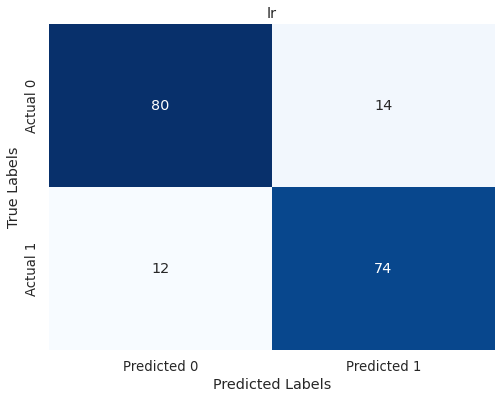

In [40]:
plot_confusion_matrix("lr",conf)

In [41]:
df = pd.DataFrame()
df["f1_test"] = [f1_test]
df["f1_train"] = f1_train
df["prec_train"] = prec_train
df["prec_test"] = prec_test
df["recall_train"] = recall_train
df["recall_test"] = recall_test
df["model"] = "Logistic Regression"
df["elapsed"] = elapsed

In [42]:
df

,f1_test,f1_train,prec_train,prec_test,recall_train,recall_test,model,elapsed
0,0.850575,0.860795,0.891176,0.840909,0.832418,0.860465,Logistic Regression,0.014716


In [43]:
df.to_csv("../results/regular/lr.csv", index=False)

In [44]:
len(test)

180